In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D
import seaborn as sns
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from q_fit import *
from q_pred import * 

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [57]:
# loss functions
def BCE_loss(y_hat,y_true):
    eps = 1e-10
    return (-((y_true*(np.log(y_hat + eps)) + (1-y_true)*(np.log(1-y_hat + eps)))))

def MSE_loss(y_true,y_hat):
    return ((y_hat - y_true)**2).mean()

In [4]:
all_data[2].action.values

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0], dtype=int64)

In [58]:
# read test data 
#df = pd.read_csv('../data/artificial_testset.csv')
df = pd.read_csv('../data/30_artificial_test_agents_non_stat.csv')

num_of_agent = df['agent'].nunique() 
num_of_action = df['action'].nunique()
num_of_trials = df['trial'].nunique()
num_of_state = df['state_onehot'].nunique()

all_data = []

for i in range(num_of_agent):
    cur_df = df[(df['agent']==i)].reset_index()
    all_data.append(cur_df)

In [59]:
# fit q-stationary

all_p_0_qs = []
bce_arr_qs = []
p_r2_arr_qs = []
norm_ll_arr_qs = []

alpha_qs, beta_qs = [],[]
mse_alpha_qs, mse_beta_qs = [],[]

for i in range(num_of_agent):
    
    res = q_fit(all_data[i])
    acc,p_0 = q_pred(all_data[i],res.x)
    
    all_p_0_qs.append(p_0)
    alpha_qs.append(res.x[0])
    beta_qs.append(res.x[1])
    
    # maybe an issue!
    loss = BCE_loss(1 - p_0, all_data[i].action.values)
    bce_arr_qs.append(loss.mean())
    p_r2_arr_qs.append( 1 - (np.array(loss.sum()) / (-len(all_data[i])*np.log(0.5))))
    norm_ll_arr_qs.append(np.exp(-loss.mean()))
    
    mse_alpha_qs.append((MSE_loss(all_data[i]['alpha']    , np.repeat(alpha_qs[i]   ,num_of_trials) ) ))
    mse_beta_qs.append((MSE_loss(all_data[i]['beta']/10  ,  np.repeat(beta_qs[i]/10 ,num_of_trials) ) ))
    
print('QS BCE '       , np.array(bce_arr_qs).mean()   )
print('QS PR2'       , np.array(p_r2_arr_qs).mean()   )
print('QS MSE alpha ' , np.array(mse_alpha_qs).mean() )
print('QS MSE beta '  , np.array(mse_beta_qs).mean()  )

print('===================')

print('QS BCE std '       , np.array(bce_arr_qs).std()   )
print('QS PR2 std'       , np.array(p_r2_arr_qs).std()   )
print('QS MSE alpha std ' , np.array(mse_alpha_qs).std() )
print('QS MSE beta std'  , np.array(mse_beta_qs).std()  )

QS BCE  0.4869248667578803
QS PR2 0.2975159094428869
QS MSE alpha  0.04516572808105893
QS MSE beta  0.07342605102774605
QS BCE std  0.11741992168548765
QS PR2 std 0.16940113871722345
QS MSE alpha std  0.10111378657701199
QS MSE beta std 0.12596802752865974


In [60]:
class GRU_RNN_TWO(nn.Module):
        
    def __init__(self,input_size, hidden_size, num_of_layers, num_alpha_embedding, num_beta_embedding, output_size, dropout):
        
        super(GRU_RNN_TWO, self).__init__()
        
        self.input_size = input_size
        self.num_alpha_embedding = num_alpha_embedding
        self.num_beta_embedding = num_beta_embedding        
        
        self.hidden_0 = nn.GRU(  
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=num_of_layers,
                    batch_first=True,
                    dropout=dropout
        )
        
        self.hidden_1 = nn.GRU(  
                    input_size=input_size + num_alpha_embedding + num_beta_embedding,
                    hidden_size=hidden_size,
                    num_layers=num_of_layers,
                    batch_first=True,
                    dropout=dropout 
        )
    
        
        self.out_alpha = nn.Linear(hidden_size, num_alpha_embedding)
        self.out_beta = nn.Linear(hidden_size, num_beta_embedding)
        
        self.relu_alpha = nn.ReLU()
        self.relu_beta = nn.ReLU()

        self.reg_alpha = nn.Linear(num_alpha_embedding, 1)
        self.reg_beta = nn.Linear(num_beta_embedding, 1)

        
        self.out_action = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):

        # parameters estimation
        output_0, hn_0 = self.hidden_0(x)
        
        output_alpha = self.out_alpha(output_0)
        output_alpha = self.relu_alpha(output_alpha)
        
        output_beta = self.out_beta(output_0)
        output_beta = self.relu_beta(output_beta)
        
        cont_output_alpha = self.reg_alpha(output_alpha)
        cont_output_beta = self.reg_beta(output_beta)
    
        # concat input 
        input_1 = torch.concat([x[0],output_alpha[0],output_beta[0]],dim=1) # cat
        input_1 = input_1.reshape(1,x.shape[1],self.input_size + self.num_alpha_embedding
                                  + self.num_beta_embedding)
        
        # action predication
        output_action, hn_1 = self.hidden_1(input_1)
        output_action = self.out_action(output_action)
        output_action = F.softmax(output_action,dim=-1)
        
        output_dis = [output_alpha, output_beta]
        output_cont = [cont_output_alpha, cont_output_beta]

        return output_dis, output_cont, output_action, hn_0, hn_1
    

In [61]:
class behavior_dataset(Dataset):
    """ 
    Transform Dataframe of an agent to torch Dataset class 
    
    Args:
        dataframe: pandas dataframe of agent behavior 
        n_parameters_embedding: number of parameters embedding class
        
    Returns: 
        torch Dataset:
        x: [reward_(t-1) , action_(t-1)] action are encoded as one-hot vectors
        y: [action_t, parameter embedding] action and parameters are encoded as one-hot vectors
        
    """
    def __init__(self,dataframe):
        
        # action one hot transformation 
        action = np.array(dataframe['action'])
        if np.all(action == action[0]):
            action = np.append(action,(1-action[0]))
            action = torch.tensor((action).reshape(len(dataframe) + 1),dtype=int)
            action_onehot = nn.functional.one_hot(action, len(action.unique()))
            # delete last one
            action_onehot = action_onehot[:-1]
        else:
            action = torch.tensor((action).reshape(len(dataframe)),dtype=int)
            action_onehot = nn.functional.one_hot(action, len(action.unique()))
        
        # reward
        reward = torch.tensor((np.array(dataframe['reward'])).reshape(len(dataframe)),dtype=int)
        
        # state one hot transformation
        state = np.array(dataframe['state'])
        state_shift = np.insert(state,-1,0)[1:]
        state_shift = torch.tensor((state_shift).reshape(len(dataframe)),dtype=int)
        state_onehot = nn.functional.one_hot(state_shift, 12)
        
        # concatinating reward and action
        reward_action_state = torch.cat([reward[ :, np.newaxis], action_onehot, state_onehot],1)

        
        # adding dummy zeros to the beginning and ignoring the last one
        reward_action_state_shift = nn.functional.pad(reward_action_state,[0,0,1,0])[:-1]
        
        # make the first trial in every block to zeros
        n_blocks = int(len(dataframe)/25) 
        reward_action_state.reshape(n_blocks,25,15)[:,0,:] = torch.zeros(size=(n_blocks,15))
        
        # network input 
        x = reward_action_state_shift
        
        
#         n_blocks = int(len(dataframe)/100)
#         x.reshape(n_blocks,100,3)[:,0,:] = torch.zeros(size=(n_blocks,3))
    
        y = action_onehot
  
        self.x = x.type(dtype=torch.float32)
        self.y = y.type(dtype=torch.float32)
        self.len = len(dataframe)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len    
    
class merge_behavior_dataset(Dataset):
    """ 
    Merge Dataset of each agent to one dataset
    
    Args:
        dataset_list: list of Dataset of all agent 
        n_trials: num_of_trials each agent was simulated
        
    Returns: 
        torch Dataset:
        x: [reward_(t-1) , action_(t-1)] all agents
        y: [action_t, parameter embedding] all agents
        
    """
    def __init__(self, dataset_list, n_trials):
        X = []
        Y = []
        for j,agent in enumerate(dataset_list):
            for i in range(n_trials[j]):
                X.append(agent[i][0])
                Y.append(agent[i][1])
                
        self.x = torch.stack(X).type(dtype=torch.float32)
        self.y = torch.stack(Y).type(dtype=torch.float32)
        self.len = len(X)   
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len
    
all_data_rnn = []

for i in range(num_of_agent):
    cur_df = all_data[i]
    cur_df = cur_df.reset_index()
    all_data_rnn.append(behavior_dataset(cur_df))
    
val_dataset = merge_behavior_dataset(all_data_rnn, np.repeat(num_of_trials,num_of_agent))

#load = torch.load(f'checkpoint_best_val_4.pth',map_location='cpu')
#load = torch.load(f'checkpoint_best_val_8.pth',map_location='cpu')
load = torch.load(f'checkpoint_best_val_9.pth',map_location='cpu')

#load = torch.load(f'checkpoint/checkpoint_best_train_5.pth',map_location='cpu')

# load = torch.load(f'checkpoint/checkpoint_best_val_5.pth',map_location='cpu')


INPUT_SIZE = 15
aHidden = 32
num_alpha_embedding = 5
num_beta_embedding = 5
OUTPUT_SIZE = 2

rnn = GRU_RNN_TWO(
              input_size=INPUT_SIZE,
              hidden_size=aHidden,
              num_of_layers=1,
              num_alpha_embedding=num_alpha_embedding,
              num_beta_embedding=num_beta_embedding,
              output_size=OUTPUT_SIZE,
              dropout=0
            )

rnn.load_state_dict(load['model_state'])
print(load['epoch'])
rnn.eval()

41


GRU_RNN_TWO(
  (hidden_0): GRU(15, 32, batch_first=True)
  (hidden_1): GRU(25, 32, batch_first=True)
  (out_alpha): Linear(in_features=32, out_features=5, bias=True)
  (out_beta): Linear(in_features=32, out_features=5, bias=True)
  (relu_alpha): ReLU()
  (relu_beta): ReLU()
  (reg_alpha): Linear(in_features=5, out_features=1, bias=True)
  (reg_beta): Linear(in_features=5, out_features=1, bias=True)
  (out_action): Linear(in_features=32, out_features=2, bias=True)
)

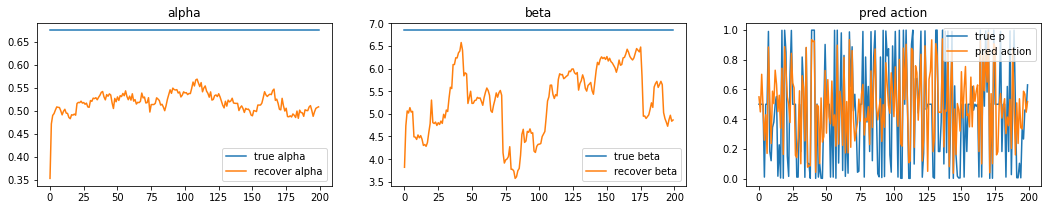

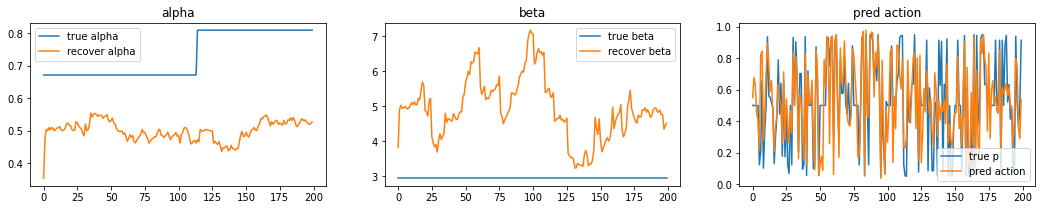

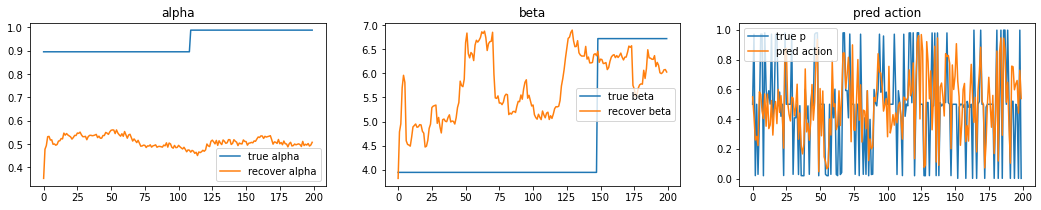

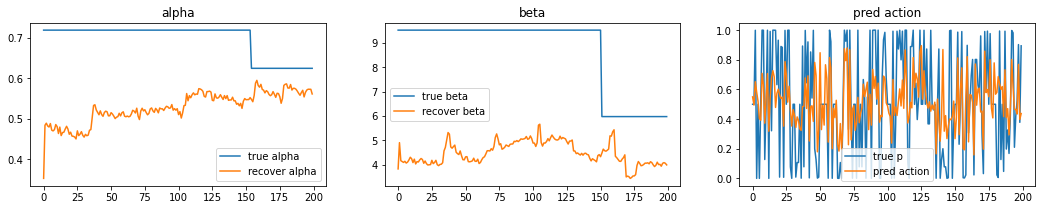

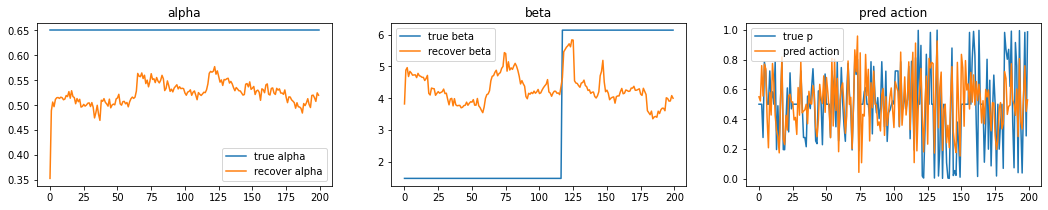

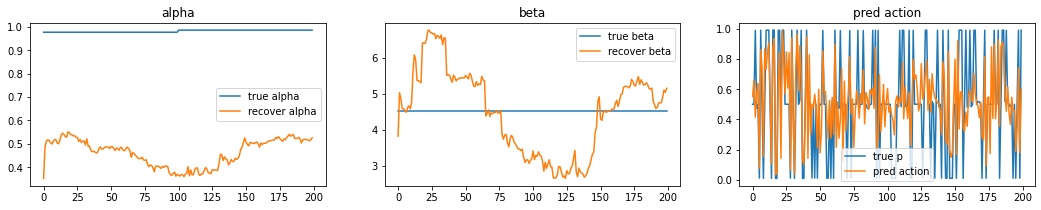

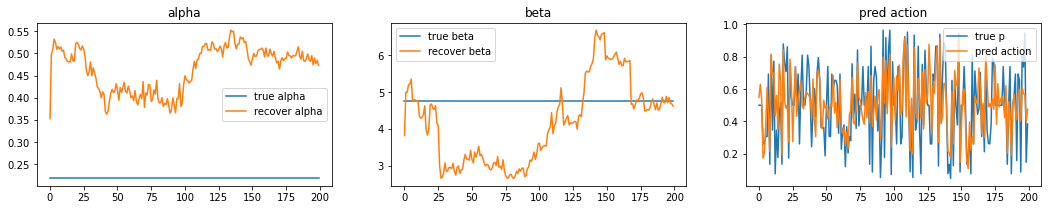

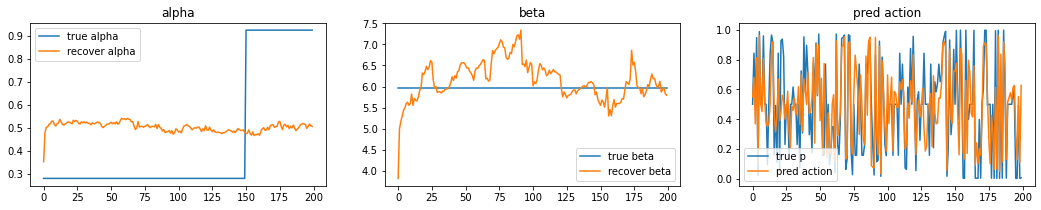

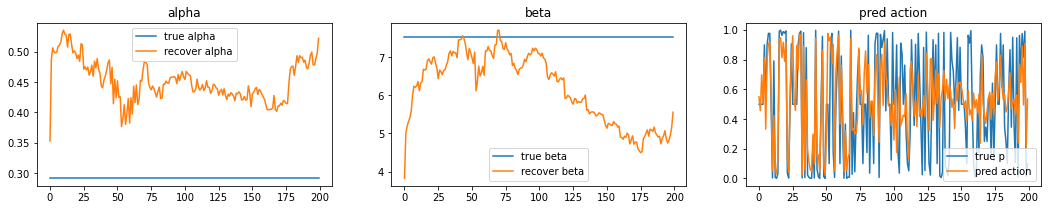

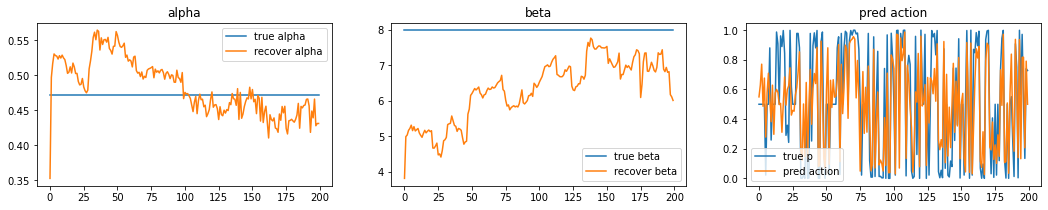

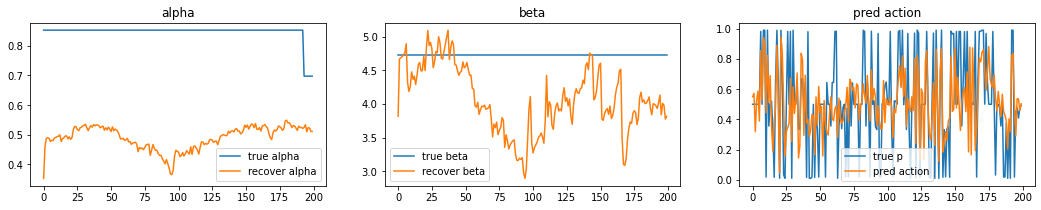

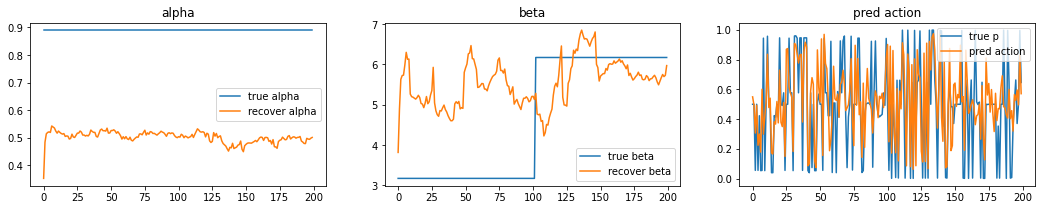

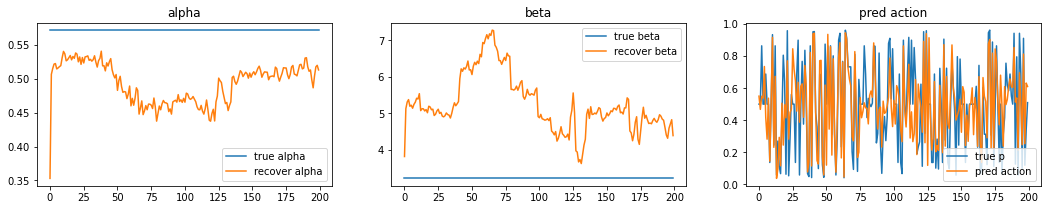

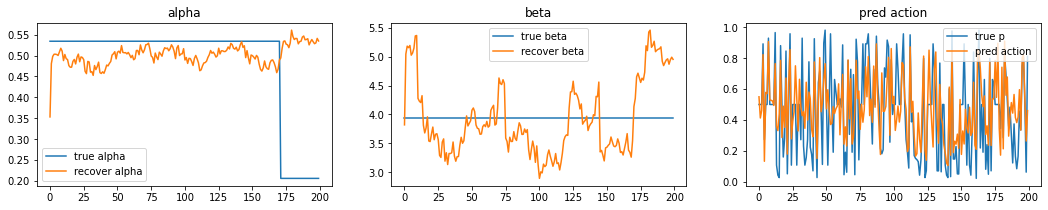

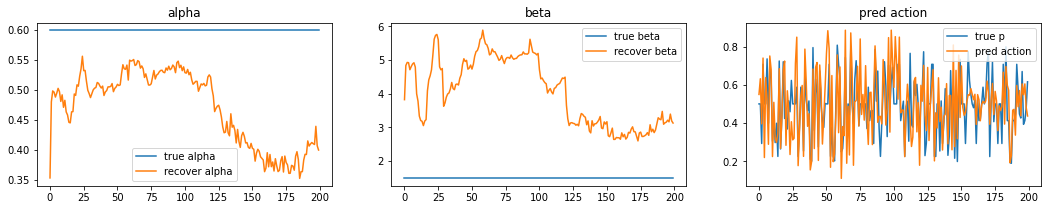

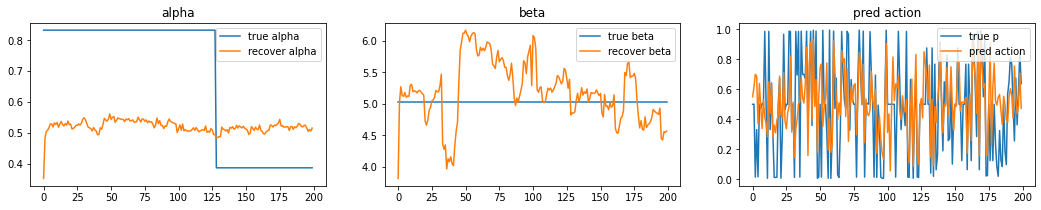

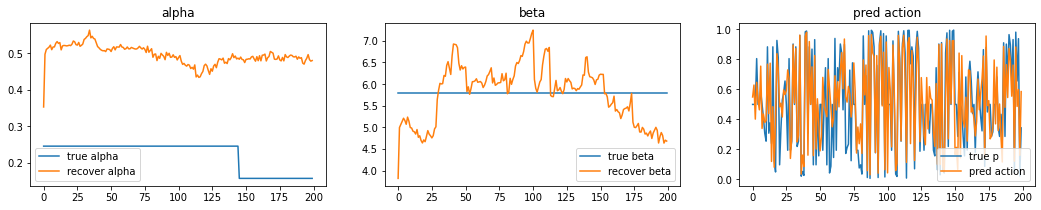

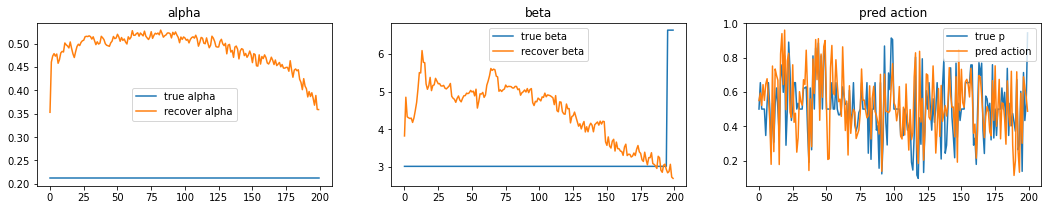

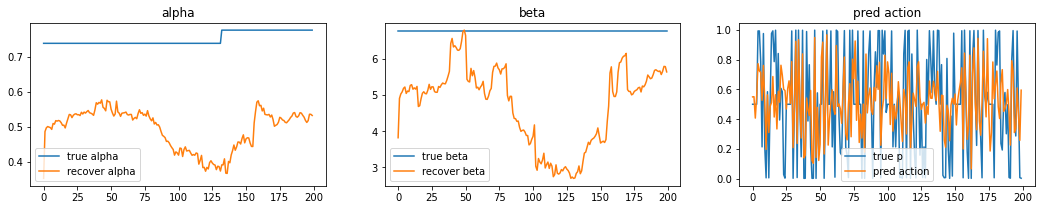

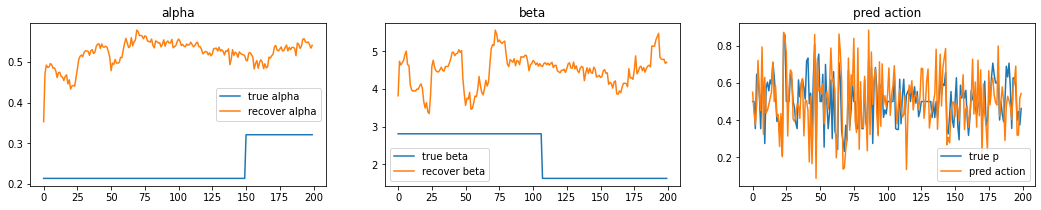

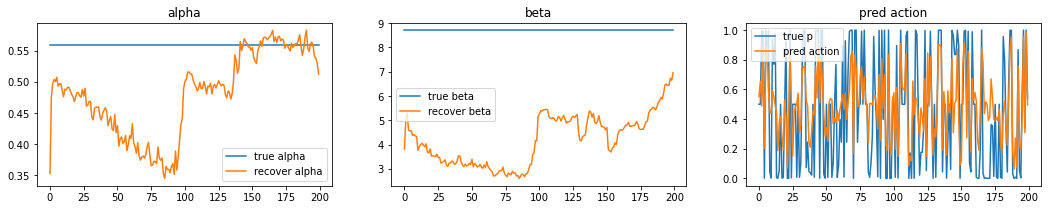

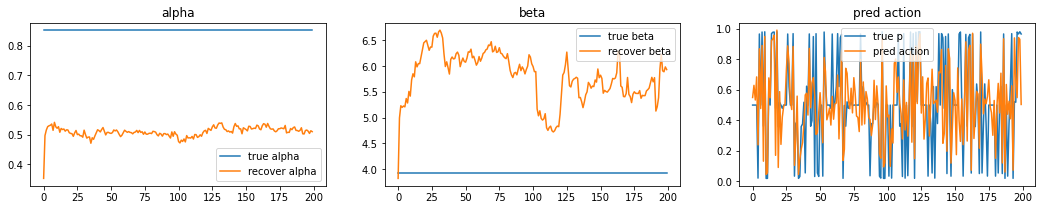

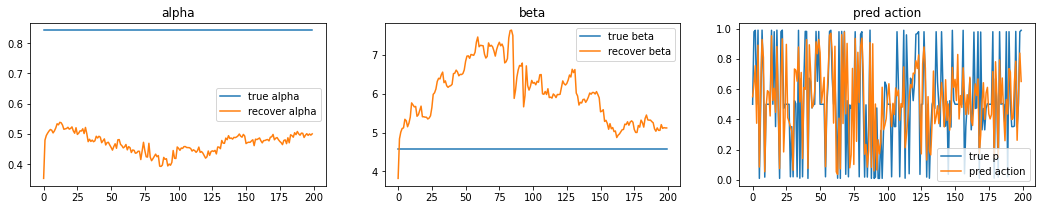

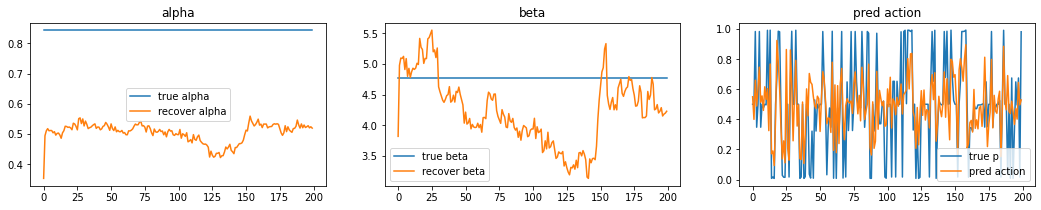

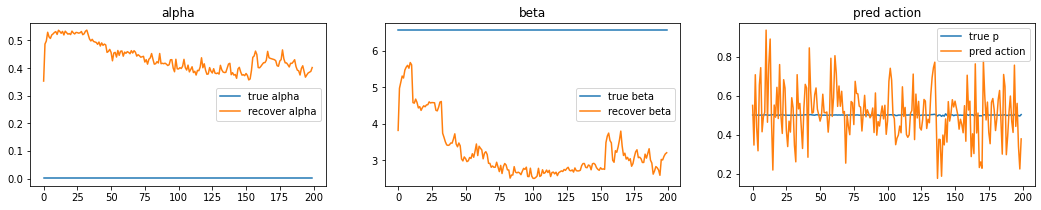

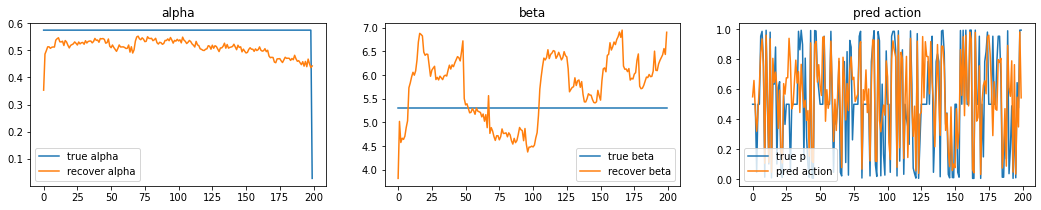

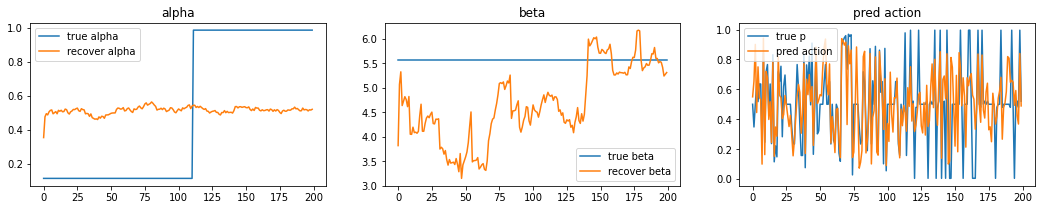

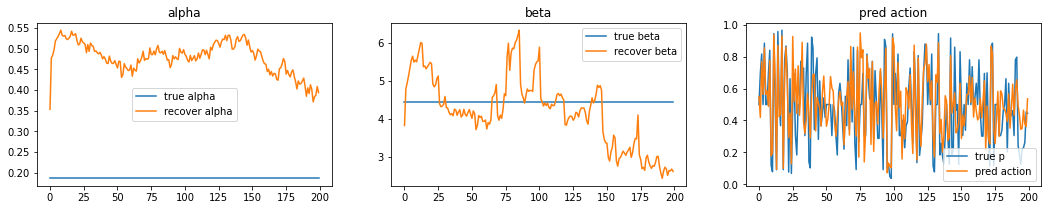

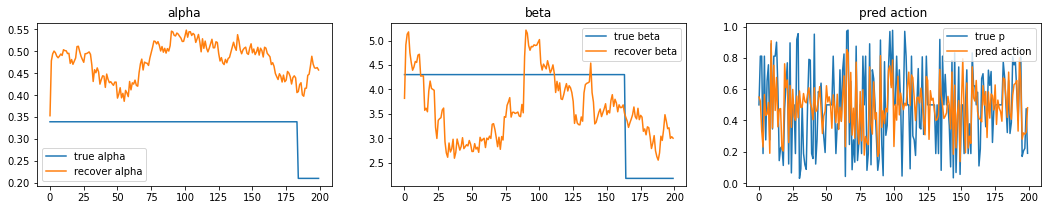

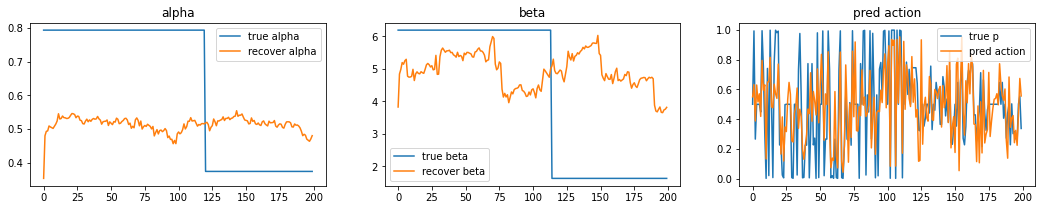

tRNN BCE  0.6020562467545582
tRNN PR2  0.13141643847097692
tRNN MSE alpha  0.08003719269444023
tRNN MSE beta  0.04181477585682738
tRNN BCE std  0.06658227750489681
tRNN PR2 std  0.09605792156740743
tRNN MSE alpha std  0.06619848978224914
tRNN MSE beta std 0.050456359007365115


In [62]:
alpha_trnn = []
beta_trnn = []
all_p_0_trnn = []

j = 0

for i in range(num_of_agent):
        
    cur_df = all_data[i]
    
    num_of_trials = len(cur_df)
        
    y_hat_dis, y_hat_cont, y_hat_action, _, _ = rnn((val_dataset[j:num_of_trials+j][0].reshape(1,num_of_trials,15)))
    y_hat_action = (y_hat_action.view(-1, num_of_action)) 
    
    alpha_trnn.append((y_hat_cont[0].cpu().detach().numpy().flatten()))    
    beta_trnn.append((y_hat_cont[1].cpu().detach().numpy().flatten()))
    all_p_0_trnn.append(((y_hat_action[:,0]).cpu().detach().numpy()))

    fig ,(ax0,ax1,ax2)  = plt.subplots(1,3,figsize=(18,3))
    ax0.plot(cur_df.alpha,label='true alpha')
    ax0.plot(alpha_trnn[i],label='recover alpha')
    ax0.set_title('alpha')
    ax0.legend()

    ax1.plot(cur_df.beta,label='true beta')
    ax1.plot(beta_trnn[i],label='recover beta')
    ax1.set_title('beta')
    ax1.legend()

    ax2.plot(1-cur_df.p_0,label='true p')
    ax2.plot(1-all_p_0_trnn[i],label='pred action')
    ax2.set_title('pred action')
    ax2.legend()

    plt.show()
    
    j += num_of_trials
    
bce_arr_trnn = []
p_r2_arr_trnn = []
norm_ll_arr_trnn = []
mse_alpha_trnn, mse_beta_trnn = [],[]

for i in range(num_of_agent):
    bce = BCE_loss(1-all_p_0_trnn[i],all_data[i]['action'])
    bce_arr_trnn.append(bce.mean())
    p_r2_arr_trnn.append(1-(np.array(bce.sum()) / (-len(all_data[i])*np.log(0.5))))
    norm_ll_arr_trnn.append(np.exp(-bce.mean()))
    mse_alpha_trnn.append( ( MSE_loss(all_data[i]['alpha']   ,alpha_trnn[i]      ) ))
    mse_beta_trnn.append(  ( MSE_loss(all_data[i]['beta']/10 ,beta_trnn[i]/10   ) ))
    
print('tRNN BCE '       , np.array(bce_arr_trnn).mean()   )
print('tRNN PR2 '       , np.array(p_r2_arr_trnn).mean()   )
print('tRNN MSE alpha ' , np.array(mse_alpha_trnn).mean() )
print('tRNN MSE beta '  , np.array(mse_beta_trnn).mean()  )

print('===================')

print('tRNN BCE std '       , np.array(bce_arr_trnn).std()   )
print('tRNN PR2 std '       , np.array(p_r2_arr_trnn).std()   )
print('tRNN MSE alpha std ' , np.array(mse_alpha_trnn).std() )
print('tRNN MSE beta std'  , np.array(mse_beta_trnn).std()  )

QPS BCE 0.487
QPS MSE alpha 0.045
QPS MSE beta 0.073
tRNN BCE 0.602
tRNN MSE alpha 0.080
tRNN MSE beta 0.042


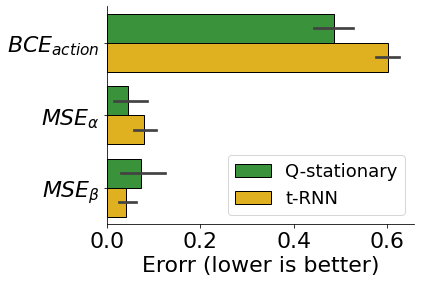

In [63]:
print('QPS BCE %.3f'          %np.array(bce_arr_qs).mean()   )
print('QPS MSE alpha %.3f'    %np.array(mse_alpha_qs).mean() )
print('QPS MSE beta %.3f'     %np.array(mse_beta_qs).mean()  )

print('=============================')

print('tRNN BCE %.3f'        %np.array(bce_arr_trnn).mean()   )
print('tRNN MSE alpha %.3f'  %np.array(mse_alpha_trnn).mean() )
print('tRNN MSE beta %.3f'   %np.array(mse_beta_trnn).mean()  )


all_res = pd.DataFrame({'Measurements':np.concatenate([
                    np.array(bce_arr_qs),np.array(mse_alpha_qs),np.array(mse_beta_qs),
                    np.array(bce_arr_trnn),np.array(mse_alpha_trnn),np.array(mse_beta_trnn)]),
           
              'Model':
                    np.repeat(['Q-stationary','t-RNN'],3*num_of_agent),
              
              'Type':
#                     np.tile(np.repeat([r'$BCE\/\/\/$'+'\n action',r'$MSE_{\alpha}$',r'$MSE_{\beta}$'],num_of_agent),3)
                      np.tile(np.repeat([r'$BCE_{action}$',r'$MSE_{\alpha}$',r'$MSE_{\beta}$'],num_of_agent),2)
             })

plt.figure(figsize=(5.5,4))
sns.barplot(data=all_res,
            y='Type',x='Measurements',hue='Model',
            palette=['tab:green','#ffc100','#1761B0'],
            edgecolor='k',
            #errorbar="se",
            orient='h'
           )

# plt.grid(alpha=0.5,axis='x')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel('Erorr (lower is better)',size=22)
plt.ylabel('',size=0)
plt.legend(fontsize=18)
sns.despine()
plt.savefig('../plots/fig_2A_H.pdf',bbox_inches='tight')
plt.show()

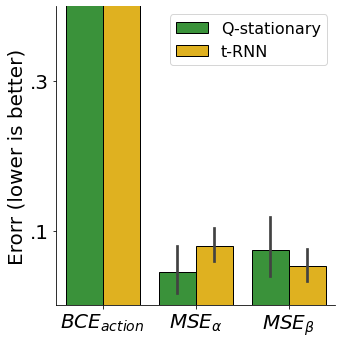

In [45]:
fig,ax1 = plt.subplots(1,1,figsize=(5,5.5))
sns.barplot(ax=ax1,data=all_res,
            x='Type',y='Measurements',hue='Model',
            palette=['tab:green','#ffc100','#1761B0'],
            edgecolor='k',
            #errorbar="se",
            orient='v'
           )

# plt.grid(alpha=0.5,axis='both')
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylabel('Erorr (lower is better)',size=20)
ax1.set_xlabel('',size=0)
ax1.set_ylim(0,0.4)
ax1.set_yticks([0.1,0.3])
ax1.legend(fontsize=16)
ax1.set_yticklabels([str(x)[1:] for x in np.round(ax1.get_yticks(), 3)])

sns.despine()
plt.savefig('../plots/fig_2A_V.pdf',bbox_inches='tight')
plt.show()


NameError: name 'alpha_bay' is not defined

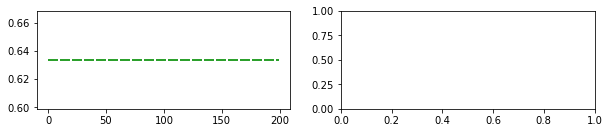

In [46]:
pla = ['#D2292D','tab:green','#ffc100','#1761B0']

for i in [15,22,8]: # range(num_of_agent): 
    
    cur = all_data[i]
    
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,1.8))
        
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=np.repeat(alpha_qs[i],num_of_trials),color=pla[1],lw=2,ls=(0, (5, 1))) # qps
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=alpha_bay[i],color=pla[2],lw=2,ls=(0, (5, 1)))# bay
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=alpha_trnn[i],color=pla[3],lw=2,ls=(0, (5, 1)))
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=cur.alpha,color=pla[0],lw=3) # target
        

    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=np.repeat(beta_qs[i],num_of_trials),color=pla[1],lw=2,ls=(0, (5, 1))) # qps
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=beta_bay[i],color=pla[2],lw=2,ls=(0, (5, 1))) # bay
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=beta_trnn[i],color=pla[3],lw=2,ls=(0, (5, 1)))
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=cur.beta,color=pla[0],lw=3)
    
    ax0.set_xticklabels([])
    ax0.set_xlim(0,num_of_trials)
    ax0.set_ylim(-0.2,1.2)
    ax0.set_ylabel(r'$\alpha$',size=25,labelpad=0)
    ax0.set_yticks([.1,.8])
    ax0.set_yticklabels([.1,0.8],size=16)
    ax0.set_yticklabels([str(x)[1:] for x in np.round(ax0.get_yticks(), 3)])
    
    ax1.set_xlim(0,num_of_trials)
    ax1.set_ylim(-0.1,10.1)
    ax1.set_ylabel(r'$\beta$',size=25,labelpad=0)
    ax1.set_yticks([1,8])
    ax1.set_yticklabels([1,8],size=16)
    ax1.set_xlabel('Trial',size=16)
    
    ax0.set_xlim(0,1000)
    ax0.set_xticks([100,500,900])
    ax0.set_xticklabels([100,500,900],size=16)
    ax0.set_xlabel('Trial',size=16)
    
    ax1.set_xlim(0,1000)
    ax1.set_xticks([100,500,900])
    ax1.set_xticklabels([100,500,900],size=16)
    

    legend_elements = [Line2D([0],[0] ,lw=4, color=pla[0], label='Target'),
                       Line2D([0],[0] ,lw=4, color=pla[1], label='Q-stationary'),
                       Line2D([0],[0] ,lw=4, color=pla[2], label='Bayesian'),
                       Line2D([0],[0] ,lw=4, color=pla[3], label='t-RNN'),
                      ]

    if i == 8:
        ax1.legend(handles=legend_elements,bbox_to_anchor=(1.05, 1),ncol=1,loc='upper left', borderaxespad=0.,
                  fontsize=14)

    sns.despine()
    plt.tight_layout()
    plt.savefig(f'../plots/fig_2B_{i}.pdf')
    plt.show()
        

NameError: name 'alpha_bay' is not defined

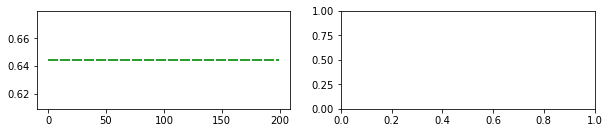

In [36]:
pla = ['#D2292D','tab:green','#ffc100','#1761B0']

for i in range(num_of_agent): 
    
    cur = all_data[i]
    
    fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,1.8))
        
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=np.repeat(alpha_qs[i],num_of_trials),color=pla[1],lw=2,ls=(0, (5, 1))) # qps
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=alpha_bay[i],color=pla[2],lw=2,ls=(0, (5, 1)))# bay
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=alpha_trnn[i],color=pla[3],lw=2,ls=(0, (5, 1)))
    sns.lineplot(ax=ax0,x=np.arange(num_of_trials),y=cur.alpha,color=pla[0],lw=3) # target
        

    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=np.repeat(beta_qs[i],num_of_trials),color=pla[1],lw=2,ls=(0, (5, 1))) # qps
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=beta_bay[i],color=pla[2],lw=2,ls=(0, (5, 1))) # bay
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=beta_trnn[i],color=pla[3],lw=2,ls=(0, (5, 1)))
    sns.lineplot(ax=ax1,x=np.arange(num_of_trials),y=cur.beta,color=pla[0],lw=3)
    
    ax0.set_xticklabels([])
    ax0.set_xlim(0,num_of_trials)
    ax0.set_ylim(-0.2,1.2)
    ax0.set_ylabel(r'$\alpha$',size=25,labelpad=0)
    ax0.set_yticks([.1,.8])
    ax0.set_yticklabels([.1,0.8],size=16)
    ax0.set_yticklabels([str(x)[1:] for x in np.round(ax0.get_yticks(), 3)])
    
    ax1.set_xlim(0,num_of_trials)
    ax1.set_ylim(-0.1,10.1)
    ax1.set_ylabel(r'$\beta$',size=25,labelpad=0)
    ax1.set_yticks([1,8])
    ax1.set_yticklabels([1,8],size=16)
    ax1.set_xlabel('Trial',size=16)
    
    ax0.set_xlim(0,1000)
    ax0.set_xticks([100,500,900])
    ax0.set_xticklabels([100,500,900],size=16)
    ax0.set_xlabel('Trial',size=16)
    
    ax1.set_xlim(0,1000)
    ax1.set_xticks([100,500,900])
    ax1.set_xticklabels([100,500,900],size=16)
    

    sns.despine()
    plt.tight_layout()

    plt.show()
        

